In [1]:
import math
import time
import imageio
import numpy as np

In [2]:
from sklearn import preprocessing
from sklearn.datasets import make_moons

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Generate Two Moons Dataset
Chapter 18 of Glassner's book describes his datset as follows (note the normalization that occurs):

![image.png](attachment:image.png)

### Define the Dataset class

In [5]:
class TwoMoonsDataset(Dataset):
    """Two Moons dataset."""

    def __init__(self, noise=0.08, n_samples=1500):
        """
        Args:
            noise (float): Amount of noise to use.
            n_samples (int): Number of samples to generate.
        """
        np.random.seed(42)
        (moons_xy, moons_labels) = make_moons(n_samples=n_samples, noise=noise)
        self.sample = preprocessing.scale(moons_xy.astype(float))
        self.target = moons_labels

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (self.sample[idx], np.reshape(self.target[idx],(1)))

In [6]:
def plot_moons(dataset, title):
    clr_list = ['#8800FF', '#FF0000']
    clrs = [clr_list[v] for v in dataset.target]

    plt.scatter(dataset.sample[:,0], dataset.sample[:,1], c=clrs, s=15, linewidths=0.5, edgecolors='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.tight_layout()
    plt.axis('equal')
    plt.xticks()
    plt.yticks()

# Define the Two-Layer Network
As noted below, Andrew Glassner includes a bias term in each activation and the network has a total of 37 parameters

![image.png](attachment:image.png)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 4, bias=True)
        self.fc3 = nn.Linear(4, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))
    
    # Return all the activations so we can plot them
    def activations(self, x):
        l1 = F.relu(self.fc1(x))
        l2 = F.relu(self.fc2(l1))
        output = torch.sigmoid(self.fc3(l2))
        return torch.cat((l1,l2,output), 1)

    def size(self):
        total_model_size = 0
        state_dict = self.state_dict()
        for param_tensor in state_dict:
            sz = state_dict[param_tensor].size()
            total_model_size += np.prod(sz)
            
        return total_model_size
    
    def get_weights(self):
        state_dict=self.state_dict()
        return np.hstack(list(map(lambda param: state_dict[param].flatten(), state_dict)))        
        
    def print(self):
        total_model_size = 0
        state_dict = self.state_dict()

        print("Model's state_dict:\n")

        # print out size of each set of parameter
        for param_tensor in state_dict:
            sz = state_dict[param_tensor].size()

            # skip empty parameters (like batch normalization history length)
            if len(sz) == 0:
                continue

            total_model_size += np.prod(sz)
            if len(sz) > 1:
                print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
            else:
                print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))
            print('{}\n'.format(state_dict[param_tensor]))

        # print out total
        print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

### Network Training Class
Put in class to encapsulate the model and device instance and hide methods. Maybe just put in module...?

In [8]:
class NetworkTrainer():
    def __init__(self, model, lr, momentum, seed=0, no_cuda=False, mini_batch_log_fn=None):
        # Initialize random number generators for determinism
        torch.manual_seed(seed)

        use_cuda = not no_cuda and torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        
        # TODO: pass in network class
        self.model = model.to(self.device)
        self.optimizer = optimizer = optim.SGD(self.model.parameters(), lr, momentum)
        
        self.mini_batch_log_fn = mini_batch_log_fn
        
        # Consider moving loss criteria into the network definition so that
        # the network defines the cost and the NetworkTrainer defines the optimizer
        self.loss_criterion = nn.MSELoss()
        
        self.epoch = 0
        
    def _train(self, train_loader):
        # Set model to be in training mode
        self.model.train()
        sample_idx = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data.float())
            loss = self.loss_criterion(output, target.float())
            loss.backward()
            self.optimizer.step()

            if self.mini_batch_log_fn is not None:
                sample_idx += len(data)
                avg_loss = loss.item() / len(data)
                self.mini_batch_log_fn(self.epoch, sample_idx, avg_loss,
                                       train_loader, self.model, self.device)

    def _test(self, test_loader):
        # Set model to be in testing mode
        self.model.eval()
        loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data.float())
                loss += self.loss_criterion(output, target.float()).item() # sum up batch loss
                pred = torch.round(output).long() # Round to 0/1
                correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(test_loader.dataset)

        return test_loss, correct

    def _run_epoch(self, train_loader, test_loader, verbose=False):
        if verbose is False:
            self._train(train_loader)
        else:
            train_start = time.perf_counter()
            self._train(train_loader)
            train_end = time.perf_counter()
            train_delta = train_end - train_start
            print("Training took {:.1f}s.\n".format(train_delta))

            test_start = time.perf_counter()
            loss, correct = _test(test_loader)
            test_end = time.perf_counter()
            test_delta = test_end - test_start

            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

            print("Testing took {:.1f}s.\n".format(test_delta))
            
    def run(self, epochs, train_loader, test_loader, verbose=False):
        # Log initial state
        if verbose is True:
            print("Initialized:")
            self.test(test_loader)
            print("")

        self.mini_batch_log_fn(1, 0, 0, train_loader, self.model, self.device)    

        # Run epochs
        for self.epoch in range(1, epochs + 1):
            self._run_epoch(train_loader, test_loader, verbose)        

# Create Tiled Gif from Multiple Initializations
This code runs a set of rows x cols initializations and saves out pngs for the decision surface every ```args.log_interval``` samples through the training data.

Once that finishes, they are read in, concatenated into a tiled image and then saved out as an animated gif of the decision surface as the optimzation progresses. 

### Functor to Visualize Cost Landscape

This functor is the callback that gets passed into the train function. It runs every ```args.log_interval``` samples. This lets us plot the decision surface periodically during training.

scikit has an example that plots decision surfaces
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [9]:
class mini_batch_functor:
    def __init__(self, seed, weight_count, iteration_count, epochs, verbose=False, filename=None, log_interval=None): 
        self.images = []
        self.verbose = verbose
        self.filename = filename
        self.seed = seed
        self.log_interval = log_interval
        self.weight_history = np.zeros((iteration_count, weight_count))
        self.weight_history_epochs = np.zeros(iteration_count)
        self.iteration = 0
    
    def __call__(self, epoch, sample_idx, avg_loss, data_loader, model, device):
        if (self.log_interval is None or
            (sample_idx != len(data_loader.dataset) and
             sample_idx % self.log_interval != 0)):
            return

        sample_total = len(data_loader.dataset)
        if self.verbose is True:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, sample_idx, sample_total,
                100. * sample_idx / sample_total, avg_loss))
        
        epoch_id = np.round(epoch - 1 + sample_idx/sample_total,2)

        # record weights
        self.weight_history[self.iteration,:] = model.get_weights()
        self.weight_history_epochs[self.iteration] = epoch_id

        img = self._plot_activations(data_loader.dataset, model, device, self.seed, epoch_id=epoch_id)
        #img = self._plot_decision_surface(data_loader.dataset, model, device, epoch_id=epoch_id)
        if self.filename is not None:
            imageio.imsave(self.filename.format(epoch_id), img)
            
        self.iteration += 1
        
    def _plot_decision_surface(self, dataset, model, device, zoom=1.0, epoch_id=None): 
        # Get samples
        samples = dataset.sample;
        X = torch.tensor(samples).float()
        X = X.to(device)

        # Count number correct
        Z = model(X)
        pred = torch.round(Z).long() # Round to 0/1
        x = torch.tensor(dataset.target)
        x = x.to(device)
        correct = pred.eq(x.view_as(pred)).sum().item()
        total = len(pred)

        # Get meshgrid for surface
        h = 0.02 * zoom   
        x_min, x_max = samples[:, 0].min() - .5, samples[:, 0].max() + .5
        y_min, y_max = samples[:, 1].min() - .5, samples[:, 1].max() + .5

        scale = (zoom-1)/2.0
        x_delta = scale * (x_max - x_min)
        x_min -= x_delta
        x_max += x_delta
        y_delta = scale * (y_max - y_min)
        y_min -= y_delta
        y_max += y_delta
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Classify each point on the grid
        X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
        X_grid = X_grid.to(device)

        Z_grid = model(X_grid).detach().cpu().numpy()

        fig = plt.figure(figsize=(4,4), dpi=64)

        # Plot decision surface
        canvas = FigureCanvas(fig)
        if epoch_id is None:
            plt.title('Decision Surface\n{} Out of {} Correct'.format(correct, total), loc='left')
        else:
            plt.title('Seed {: >#5} - Epoch {: >#6.2f}\n{}/{} Correct'.format(self.seed, epoch_id, correct, total))        
        plt.tight_layout()

        Z_grid = Z_grid.reshape(xx.shape)
        cm = plt.cm.RdBu
        plt.contourf(xx, yy, Z_grid,
                     norm=mpl.colors.Normalize(vmin=0.,vmax=1.),
                     cmap=cm, alpha=.8)

        # Plot samples
        X = dataset.sample
        y_train=dataset.target
        cm_bright = ListedColormap(['#FF0000', '#8800FF'])
        plt.scatter(X[:, 0], X[:, 1], s=15, linewidths=0.5,
                    c=y_train, norm=mpl.colors.Normalize(vmin=0.,vmax=1.),
                    cmap=cm_bright, edgecolors='k')

        # Convert figure canvas to an image
        canvas.draw()
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))

        plt.close(fig)

        return(image)

    def _plot_activations(self, dataset, model, device, seed, epoch_id=None, zoom=1.): 
        # Get samples
        model.eval()
        samples = dataset.sample;
        X = torch.tensor(samples).float()
        X = X.to(device)

        # Count number correct
        Z = model(X)
        pred = torch.round(Z).long() # Round to 0/1
        x = torch.tensor(dataset.target)
        x = x.to(device)
        correct = pred.eq(x.view_as(pred)).sum().item()
        total = len(pred)

        # Get meshgrid for surface
        h = 0.02 * zoom   
        x_min, x_max = samples[:, 0].min() - .5, samples[:, 0].max() + .5
        y_min, y_max = samples[:, 1].min() - .5, samples[:, 1].max() + .5

        scale = (zoom-1)/2.0
        x_delta = scale * (x_max - x_min)
        x_min -= x_delta
        x_max += x_delta
        y_delta = scale * (y_max - y_min)
        y_min -= y_delta
        y_max += y_delta
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Classify each point on the grid
        X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
        X_grid = X_grid.to(device)

        Z_grid = model.activations(X_grid).detach().cpu().numpy()

        fig = plt.figure(constrained_layout=True, figsize=(4,4), dpi=64)

        gs = GridSpec(5, 6, figure=fig)
        ax_11 = fig.add_subplot(gs[0, 0])
        ax_12 = fig.add_subplot(gs[1, 0])
        ax_13 = fig.add_subplot(gs[2, 0])
        ax_14 = fig.add_subplot(gs[3, 0])
        ax_21 = fig.add_subplot(gs[0, 1])
        ax_22 = fig.add_subplot(gs[1, 1])
        ax_23 = fig.add_subplot(gs[2, 1])
        ax_24 = fig.add_subplot(gs[3, 1])
        ax_out = fig.add_subplot(gs[:-1, 2:])
        ax_w = fig.add_subplot(gs[4, :])

        if epoch_id is None:
            fig.suptitle('Activations and Decision Surface\n{} Out of {} Correct'.format(correct, total), loc='left')
        else:
            fig.suptitle('Seed {: >#5} - Epoch {: >#6.2f}\n{}/{} Correct'.format(seed, epoch_id, correct, total))        

        #plt.tight_layout()

        # Plot activations and output
        for i, ax in enumerate(fig.axes[:-1]):
            ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

            Z_grid_i = Z_grid[:,i].reshape(xx.shape)
            cm = plt.cm.RdBu
            ax.contourf(xx, yy, Z_grid_i,
                        norm=mpl.colors.Normalize(vmin=0.,vmax=1.),
                        cmap=cm, alpha=.8)

            # Plot samples
            X = dataset.sample
            y_train=dataset.target
            cm_bright = ListedColormap(['#FF0000', '#8800FF'])
            ax.scatter(X[:, 0], X[:, 1], s=1, linewidths=0.1,
                        c=y_train, norm=mpl.colors.Normalize(vmin=0.,vmax=1.),
                        cmap=cm_bright, edgecolors='k')

        # Plot weights
        fig.axes[-1].plot(self.weight_history_epochs[:self.iteration+1], self.weight_history[:self.iteration+1,:])

        # Convert figure canvas to an image
        canvas = FigureCanvas(fig)
        canvas.draw()
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))

        plt.close(fig)

        return(image)    

In [10]:
def write_animation(args, train_loader, test_loader):
    rand_max = 10000
    np.random.seed(args.seed)
    rand_offset = np.random.randint(rand_max)
    np.random.seed(args.seed)

    sample_total = len(train_loader.dataset)

    # Dump pngs for each file into a directory
    for row in range(args.rows):
        for col in range(args.cols):
            # Create image sequence for one tile
            seed = np.random.randint(rand_max)-rand_offset
            print('seeding[{}][{}] = {}'.format(row, col, seed))
    
            fn = 'two_moons_optimization_{}_{}_'.format(row,col) + '{:0>#6.2f}.png'
            
            model = Net()
            weight_count = model.size()
            iteration_count = np.int64(np.ceil(len(train_loader)/args.log_interval))*args.epochs + 1
            callback=mini_batch_functor(seed, weight_count, iteration_count, args.epochs, log_interval=args.log_interval, verbose=False, filename=fn)

            trainer = NetworkTrainer(model, args.lr, args.momentum, seed=seed,
                                     no_cuda=args.no_cuda, mini_batch_log_fn=callback)
            trainer.run(args.epochs, train_loader, test_loader, verbose=False)

            # Writ
            gif_filename = 'two_moons_{}_{}_{}.gif'.format(row, col, args.epochs)
            with imageio.get_writer(gif_filename, mode='I') as writer:
                minibatch_count = np.ceil(sample_total / args.log_interval).astype(int)
                for epoch in range(0, args.epochs):
                    print('processing epoch [{},{}] {}/{}'.format(row, col, epoch+1, args.epochs))

                    if epoch is args.epochs-1:
                        minibatch_count += 1
                    for minibatch in range(minibatch_count):
                        sample_idx = np.min((sample_total, args.log_interval*minibatch))
                        epoch_id = np.round(epoch + sample_idx/sample_total,2)

                        fn = 'two_moons_optimization_{}_{}_{:0>#6.2f}.png'.format(row,col,epoch_id)
                        writer.append_data(imageio.imread(fn))

    # Read pngs and turn into a tiled gif
    gif_filename = 'two_moons_{}x{}_{}.gif'.format(args.rows, args.cols, args.epochs)
    with imageio.get_writer(gif_filename, mode='I') as writer:
        minibatch_count = np.ceil(sample_total / args.log_interval).astype(int)
        for epoch in range(0, args.epochs):
            print('processing epoch {}/{}'.format(epoch+1, args.epochs))

            if epoch is args.epochs-1:
                minibatch_count += 1
            for minibatch in range(minibatch_count):
                sample_idx = np.min((sample_total, args.log_interval*minibatch))
                epoch_id = np.round(epoch + sample_idx/sample_total,2)

                images = []
                for row in range(args.rows):
                    img_row = []
                    for col in range(args.cols):
                        fn = 'two_moons_optimization_{}_{}_{:0>#6.2f}.png'.format(row,col,epoch_id)
                        img_row.append(imageio.imread(fn))
                    images.append(img_row)
                tiled_image = np.vstack(list(map(lambda row: np.hstack(row), images)))
                writer.append_data(tiled_image)

    return gif_filename

In [11]:
# Training settings
class Args:
    train_size=1500
    test_size=1500
    batch_size=1
    test_batch_size=1500
    lr=0.01
    momentum=0.0
    no_cuda=False
    epochs=50
    log_interval=750
    rows = 4
    cols = 4
    seed=0
    save_checkpoints=False
    load_checkpoint=None #'mnist_012.pth'

In [12]:
def main():
    args = Args
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    # DataLoaders for train and test data
    train_loader = torch.utils.data.DataLoader(
        TwoMoonsDataset(n_samples=args.train_size, noise=0.08),
        batch_size=args.batch_size,
        **kwargs)
    test_loader = torch.utils.data.DataLoader(
        TwoMoonsDataset(n_samples=args.test_size, noise=0.08),
        batch_size=args.test_batch_size,
        **kwargs)

    # Plot the two datasets to make sure they look right
    plt.figure(figsize=(8,12), dpi=150)
    plt.subplot(3, 2, 1)
    plot_moons(train_loader.dataset, 'Training Set')

    plt.subplot(3, 2, 2)
    plot_moons(test_loader.dataset, 'Test Set')
    plt.show()
    
    # Print Network Dimensions and Weights
    # We show 37 parameters below, which matches Glassners
    Net().print()

    filename = write_animation(args, train_loader, test_loader)
    
    print(filename)
    plt.imshow(imageio.imread(filename))
    plt.show()

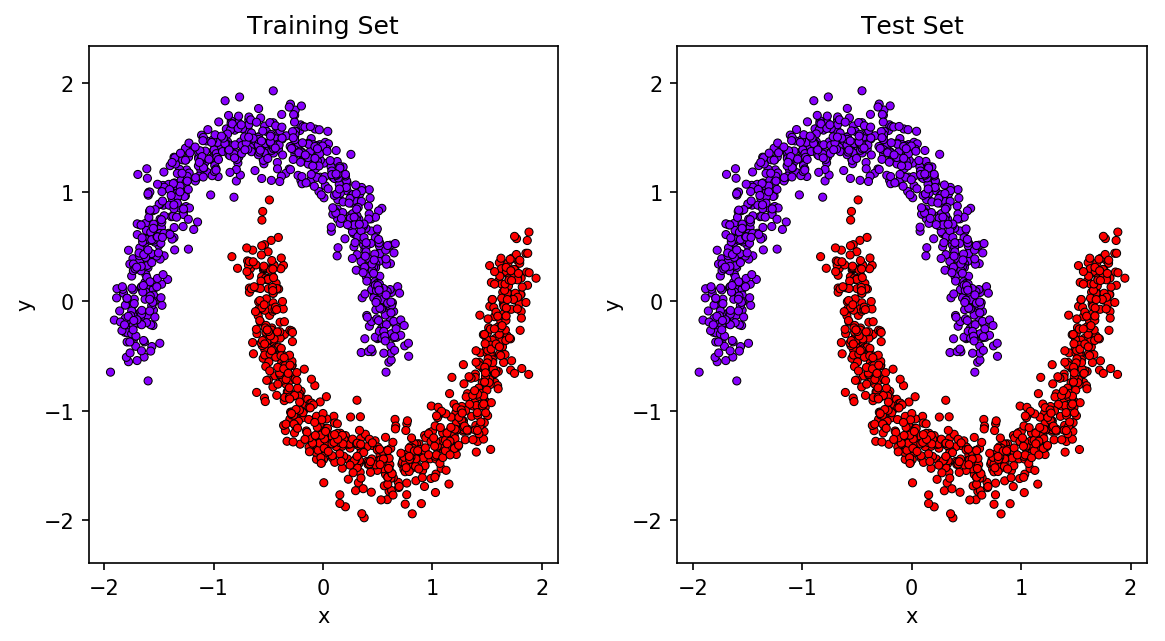

Model's state_dict:

fc1.weight       torch.Size([4, 2])         : 4 x 2 = 8
tensor([[-0.3250,  0.3665],
        [-0.1670,  0.1992],
        [-0.0902,  0.3865],
        [ 0.3776,  0.2226]])

fc1.bias         torch.Size([4])            : 4
tensor([ 0.2915, -0.6891, -0.5256, -0.0222])

fc2.weight       torch.Size([4, 4])         : 4 x 4 = 16
tensor([[ 0.1301, -0.1822,  0.2224,  0.1523],
        [ 0.0201,  0.3156, -0.2701, -0.4128],
        [ 0.3648,  0.3207,  0.4516, -0.4401],
        [ 0.3650, -0.0254, -0.2195,  0.3340]])

fc2.bias         torch.Size([4])            : 4
tensor([-0.4707, -0.2751,  0.2666,  0.2166])

fc3.weight       torch.Size([1, 4])         : 1 x 4 = 4
tensor([[-0.3429, -0.0504, -0.3640, -0.2198]])

fc3.bias         torch.Size([1])            : 1
tensor([0.2437])


Total Model Size                            : 37
seeding[0][0] = 0
processing epoch [0,0] 1/50
processing epoch [0,0] 2/50
processing epoch [0,0] 3/50
processing epoch [0,0] 4/50
processing epoch [0,0] 5/50


processing epoch [1,1] 4/50
processing epoch [1,1] 5/50
processing epoch [1,1] 6/50
processing epoch [1,1] 7/50
processing epoch [1,1] 8/50
processing epoch [1,1] 9/50
processing epoch [1,1] 10/50
processing epoch [1,1] 11/50
processing epoch [1,1] 12/50
processing epoch [1,1] 13/50
processing epoch [1,1] 14/50
processing epoch [1,1] 15/50
processing epoch [1,1] 16/50
processing epoch [1,1] 17/50
processing epoch [1,1] 18/50
processing epoch [1,1] 19/50
processing epoch [1,1] 20/50
processing epoch [1,1] 21/50
processing epoch [1,1] 22/50
processing epoch [1,1] 23/50
processing epoch [1,1] 24/50
processing epoch [1,1] 25/50
processing epoch [1,1] 26/50
processing epoch [1,1] 27/50
processing epoch [1,1] 28/50
processing epoch [1,1] 29/50
processing epoch [1,1] 30/50
processing epoch [1,1] 31/50
processing epoch [1,1] 32/50
processing epoch [1,1] 33/50
processing epoch [1,1] 34/50
processing epoch [1,1] 35/50
processing epoch [1,1] 36/50
processing epoch [1,1] 37/50
processing epoch [1,

processing epoch [2,2] 38/50
processing epoch [2,2] 39/50
processing epoch [2,2] 40/50
processing epoch [2,2] 41/50
processing epoch [2,2] 42/50
processing epoch [2,2] 43/50
processing epoch [2,2] 44/50
processing epoch [2,2] 45/50
processing epoch [2,2] 46/50
processing epoch [2,2] 47/50
processing epoch [2,2] 48/50
processing epoch [2,2] 49/50
processing epoch [2,2] 50/50
seeding[2][3] = -133
processing epoch [2,3] 1/50
processing epoch [2,3] 2/50
processing epoch [2,3] 3/50
processing epoch [2,3] 4/50
processing epoch [2,3] 5/50
processing epoch [2,3] 6/50
processing epoch [2,3] 7/50
processing epoch [2,3] 8/50
processing epoch [2,3] 9/50
processing epoch [2,3] 10/50
processing epoch [2,3] 11/50
processing epoch [2,3] 12/50
processing epoch [2,3] 13/50
processing epoch [2,3] 14/50
processing epoch [2,3] 15/50
processing epoch [2,3] 16/50
processing epoch [2,3] 17/50
processing epoch [2,3] 18/50
processing epoch [2,3] 19/50
processing epoch [2,3] 20/50
processing epoch [2,3] 21/50
pr

processing epoch 24/50
processing epoch 25/50
processing epoch 26/50
processing epoch 27/50
processing epoch 28/50
processing epoch 29/50
processing epoch 30/50
processing epoch 31/50
processing epoch 32/50
processing epoch 33/50
processing epoch 34/50
processing epoch 35/50
processing epoch 36/50
processing epoch 37/50
processing epoch 38/50
processing epoch 39/50
processing epoch 40/50
processing epoch 41/50
processing epoch 42/50
processing epoch 43/50
processing epoch 44/50
processing epoch 45/50
processing epoch 46/50
processing epoch 47/50
processing epoch 48/50
processing epoch 49/50
processing epoch 50/50
two_moons_4x4_50.gif


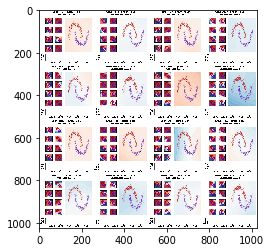

In [13]:
if __name__ == "__main__":
    main()